**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/machinelearning/blob/main/100-neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# Introduction

- An _Artificial neural network_ (_ANN_) is a Machine Learning model inspired by the networks of biological neurons found in our brains.
  
  ![](img/brain.png)
  - Biological neurons produce short electrical impulses called action potentials (APs, or just signals).
  - These signals travel along the axons and make the synapses release chemical signals called neurotransmitters. 
  - When a neuron receives a sufficient amount of these neurotransmitters within a few milliseconds, it fires its own electrical impulses.
  - Thus, individual biological neurons seem to behave in a rather simple way, but they are organized in a vast network of billions, with each neuron typically connected to thousands of other neurons.
- ANNs are at the very core of Deep Learning. 
- They are versatile, powerful, and scalable, making them ideal to tackle large and highly complex Machine Learning tasks such as 
  - classifying billions of images (e.g.,Google Images)
  - powering speech recognition services (e.g., Apple’s Siri)
  - recommending the best videos to watch to hundreds of millions of users every day (e.g., YouTube)
  - learning to beat the world champion at the game of Go (DeepMind’s AlphaGo)


# Perceptrons
- The Perceptron is one of the simplest ANN architectures, invented in 1957.
- It is based on an artificial neuron called a _threshold logic unit_ (TLU), or sometimes a linear threshold unit (LTU).
- The inputs and output are numbers and each input connection is associated with a weight.
- The TLU computes a weighted sum of its inputs: $z = w_1x_1 + w_2x_2 + ... + w_nx_n$
  ![](img/tlu.png)

The most common step function used in Perceptrons is the Heaviside step function. Sometimes the sign function is used instead.

![](img/step.png)
- A single TLU can be used for simple linear binary classification. 
- It computes a linear combination of the inputs
  - if the result exceeds a threshold, it outputs the positive class. 
  - otherwise it outputs the negative class (just like a Logistic Regression or linear SVM classifier). 
- You could, for example, use a single TLU to classify iris flowers based on petal length and width (also adding an extra bias feature x = 1, just like we did in previous chapters).   
  
- Training a TLU in this case means finding the right values for $w_0$ , $w_1$ and $w_2$.

- A _Perceptron_ is simply composed of a single layer of TLUs, with each TLU connected to all the inputs.
- When **all the neurons in a layer are connected to every neuron in the previous layer** (i.e., its input neurons), the layer is called a _fully connected layer_, or a _dense layer_.
- The inputs of the Perceptron are fed to special passthrough neurons called input neurons: they output whatever input they are fed. 
- All the input neurons form the input layer. 
- Moreover, an extra bias feature is generally added ($x_0 = 1$): it is typically represented using a special type of neuron called a bias neuron, which outputs 1 all the time. 
- A Perceptron with two inputs and three outputs is represented here:
 ![](img/perceptron.png)
 - This Perceptron can classify instances simultaneously into three different binary classes, which makes it a multioutput classifier.
 - The following equation makes it possible to efficiently compute the outputs of a layer of artificial neurons for several instances at once.
  $$
  h_{\mathbf{W},b}(\mathbf{X}) = \phi(\mathbf{XW} + \mathbf{b})
  $$

With:
- $\mathbf{X}$ = matrix of input features. It has one row per instance and one column per feature.
- $\mathbf{W}$ = weight matrix containing all the connection weights except for the ones from the bias neuron. It has one row per input neuron and one column per artificial neuron in the layer.
- $\mathbf{b}$ = bias vector containing all the connection weights between the bias neuron and the artificial neurons. It has one bias term per artificial neuron.
- $\phi$ = activation function. When the artificial neurons are TLUs, it is a step function (but we will discuss other activation functions shortly).

Scikit-Learn provides a `Perceptron` class that implements a single-TLU network.

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

Let's use a Percetron on the iris dataset. 

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)   # is it an iris_setosa? 

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [88]:
y_pred

array([1])

- The Perceptron learning algorithm strongly resembles Stochastic Gradient Descent. 
- In fact, Scikit-Learn’s Perceptron class is equivalent to using an SGDClassifier with the following hyperparameters: `loss="perceptron"`, `learning_rate="constant"`,
`eta0=1` (the learning rate), and `penalty=Non`e (no regularization).
- Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class probability; rather, they make predictions based on a hard threshold. 
- This is one reason to prefer Logistic Regression over Perceptrons.
- Perceptions suffer from a number of serious weaknesses: they are incapable of solving some trivial problems, e.g., the Exclusive OR (XOR) classification problem (because it is not linearly separable).
- Some of the limitations of Perceptrons can be eliminated by stacking multiple Perceptrons. 
- The resulting ANN is called a Multilayer Perceptron (MLP).

# The Multilayer Perceptron and Backpropagation

- When an ANN contains a deep stack of hidden layers, it is called a _deep neural network_ (DNN).
![](img/mlp.png)

_Architecture of a Multilayer Perceptron with two inputs, one hidden layer of four neurons, and three output neurons (the bias neurons are shown here, but usually they are implicit)_

**NOTE**  

The signal flows only in one direction (from the inputs to the outputs), so this architecture is an example of a _feedforward neural network_ (FNN).

**ALGORITHM**

- The algorithm that is used for training MLP's was published in 1986 and is called _backpropagation_. 
- The algorithm looks likes this:
  - Initialize all the hidden layers’ connection weights randomly. 
  - It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. Each pass through the full set is called an _epoch_.
  - **Forward pass**
    - Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. 
    - The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). 
    - The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. 
    - The forward pass is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.
  - **Backward pass**
    - The algorithm measures the network’s output error (i.e., it uses a loss function that compares the desired output and the actual output of the network, and returns some measure of the error).
    - Then it computes how much each output connection contributed to the error.
    - The algorithm then measures how much of these error contributions came from each connection in the layer below, working backward until the algorithm
reaches the input layer.
    - This reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network (hence the name of the algorithm). 
    - Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed. Note the weights are updated after every mini-batch.

# Activation functions

For this algorithm to work properly, its authors made a key change to the MLP’s architecture: they replaced the step function with the logistic (sigmoid) function
$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

This was essential because the step function contains only flat segments, so there is no gradient to work with (Gradient Descent cannot move on a flat surface), while the logistic function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step. 
In fact, the backpropagation algorithm works well with many other activation functions, not just the logistic function. Here are two other popular choices:

The _hyperbolic tangent_ function:
$$
tanh(z) = 2σ(2z) – 1
$$
- Just like the logistic function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function). 
- That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.

The _Rectified Linear Unit_ function:
$$
ReLU(z) = max(0, z)
$$
- is continuous but unfortunately not differentiable at z = 0 (the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is 0 for z < 0. 
- In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. 
- Most importantly, the fact that it does not have a maximum output value helps reduce some issues during Gradient Descent. 

![](img/activation_functions_plot.png)



## Why do we need activation functions?
- If you chain several linear transformations, all you get is a linear transformation. 
- For example, if f(x) = 2x + 3 and g(x) = 5x – 1, then chaining these two linear functions gives you another linear function: f(g(x)) = 2(5x – 1) + 3 = 10x + 1. 
- So if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can’t solve very complex problems with that. 
- Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.

# Regression MLPs
- If you want to predict a single value (e.g., the price of a house, given many of its features), then you just need a single output neuron: its output is the predicted value. 
- For multivariate regression (i.e., to predict multiple values at once), you need one output neuron per output dimension. For example, to locate the center of an object in an image, you need to predict 2D coordinates, so you need two output neurons.
- In general, when building an MLP for regression, you do not want to use any activation function for the output neurons, so they are free to output any range of values.
- If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer. 
- Alternatively, you can use the softplus activation function, which is a smooth variant of ReLU: softplus(z) = log(1 + exp(z)). It is close to 0 when z is negative, and close to z when z is positive. 
- Finally, if you want to guarantee that the predictions will fall within a given range of values, then you can use the logistic function or the hyperbolic tangent, and then scale the labels to the appropriate range: 0 to 1 for the logistic function and –1 to 1 for the hyperbolic tangent.
- The loss function to use during training is typically the mean squared error, but if you have a lot of outliers in the training set, you may prefer to use the mean absolute error instead.
- A typical regression MLP architecture:

|Hyperparameter|Typical value|
|---|---|
|# input neurons|One per input feature (e.g. 28x28 = 784 for MNIST)|
|# hidden layers|Depends on the problem, but typically 1 to 5|
|# neurons per hidden layer|Depends on the problem, but typically 10 to 100|
|# output neurons|1 per prediction dimension|
|Hidden activation|mostly ReLU|
|Output activation|None, or ReLU/softplus (if positive outputs) or logistic/tanh (if bounded outputs)|
|Loss function|MSE or MAE|


  

# Classification MLPs
- For a binary classification problem, you just need a single output neuron using the logistic activation function: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class.
- The estimated probability of the negative class is equal to one minus that number.
- MLPs can also easily handle **multilabel binary classification** tasks. For example, you could have an email classification system that predicts whether each incoming email is ham or spam, and simultaneously predicts whether it is an urgent or nonurgent email. In this case, you would need two output neurons, both using the logistic activation function: the first would output the probability that the email is spam, and the second would output the probability that it is urgent.
- If each instance can belong only to a single class, out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activation function for the whole output layer (see figure below).
![](img/mlp_classification.png)
-  The softmax function (introduced in Chapter 4) will ensure that all the estimated probabilities are between 0 and 1 and that they add up to 1 (which is required if the classes are exclusive. This is called **multiclass classification**.
- A typical classification MLP architecture:

|Hyperparameter|Binary Classification|Multilabel binary classification|Multiclass classification|
|---|---|---|---|
|Input and hidden layers|Same as regression|Same as regression|Same as regression|
|# output neurons|1|1 per label|1 per class|
|Output activation|Logistic|Logistic|Softmax|
|Loss function|Cross entropy|Cross entropy|Cross entropy|

- The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). 
- Minimizing the cost function using **cross entropy**, should lead to this objective because it penalizes the model when it estimates a low probability for a target class (so when the actual probability should be one).

# Implementing MLPs with Keras
- Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate, and execute all sorts of neural networks. 
- Its documentation (or specification) is available at https://keras.io/.
- It is based on a Tensorflow backend. 
- The most popular Deep Learning library, after Keras and TensorFlow, is Facebook’s PyTorch library. The good news is that its API is quite similar to Keras’s (in part because both APIs were inspired by Scikit-Learn and Chainer), so once you know Keras, it is not difficult to switch to PyTorch.
## Building an Image Classifier
- First, we need to load a dataset. In this chapter we will tackle Fashion MNIST, which is a drop-in replacement of MNIST (introduced in Chapter 3). It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse, and the problem turns out to be significantly more challenging than MNIST. 
- For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST.

First let's import TensorFlow and Keras.

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
tf.__version__

'2.8.0'

In [11]:
keras.__version__

'2.8.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [14]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

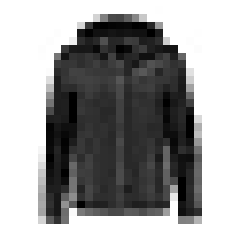

In [16]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [19]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

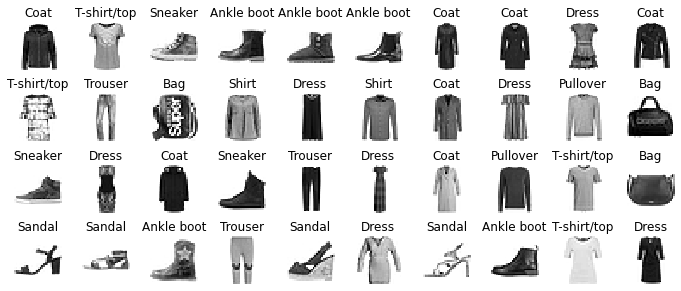

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Creating the model using the Sequential API

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the `Sequential` model:

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Let’s go through this code line by line: 
- The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. 
- This is called the Sequential API.
- Next, we build the first layer and add it to the model. It is a Flatten layer whose role is to convert each input image into a 1D array.
- This layer does not have any parameters; it is just there to do some simple preprocessing. 
- Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances. 
- Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the
neurons and their inputs. It also manages a vector of bias terms (one per neuron).
- Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
- Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).


In [26]:
model.layers

The model’s `summary()` method displays all the model’s layers, including each layer’s name (which is automatically generated unless you
set it when creating the layer), its output shape (`None` means the batch size can be anything), and its number of parameters. The summary ends with
the total number of parameters

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


- Note that Dense layers often have a lot of parameters. 
- For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! 
-  This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.
- We will come back to this later.



In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` methods. For a `Dense` layer, this includes both the connection weights and the bias terms:

In [30]:
weights, biases = hidden1.get_weights()

In [31]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

Notice that 
- the `Dense` layer initialized the connection weights randomly (which is needed to break symmetry, as we discussed earlier)
- the biases were initialized to zeros, which is fine.

## Compiling the model
- After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use. 
- Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

- We use the "sparse_categorical_crossentropy" loss because we have sparse (**input**) labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 
- If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0.,0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. 
- If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.
- Regarding the optimizer, "sgd" means that we will train the model using simple Stochastic Gradient Descent. In other words, Keras will perform the backpropagation algorithm described earlier. 
- Finally, since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.

**TIP** 

- If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the `keras.utils.to_categorical()` function. 
- To go the other way round, use the np.argmax() function with axis=1.

## Training and evaluating the model
Now the model is ready to be trained. For this we simply need to call its `fit()` method:

In [46]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2204 - accuracy: 0.9198 - val_loss: 0.2891 - val_accuracy: 0.8948
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2174 - accuracy: 0.9215 - val_loss: 0.2943 - val_accuracy: 0.8976
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2138 - accuracy: 0.9231 - val_loss: 0.3788 - val_accuracy: 0.8644
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2104 - accuracy: 0.9241 - val_loss: 0.2919 - val_accuracy: 0.8970
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2083 - accuracy: 0.9244 - val_loss: 0.2839 - val_accuracy: 0.8960
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2033 - accuracy: 0.9274 - val_loss: 0.3019 - val_accuracy: 0.8920
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2006 - accuracy: 0.9294 - val_loss: 0.2926 - val_accuracy:

- We passed a validation set (this is optional). Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. 
- If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data
mismatch between the training set and the validation set).

The fit() method returns a History object containing 
- the training parameters (`history.params`), 
- the list of epochs it went through (`history.epoch`)
- a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you use this dictionary to create a pandas DataFrame and call its plot() method, you get the learning curves

In [117]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [118]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [119]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

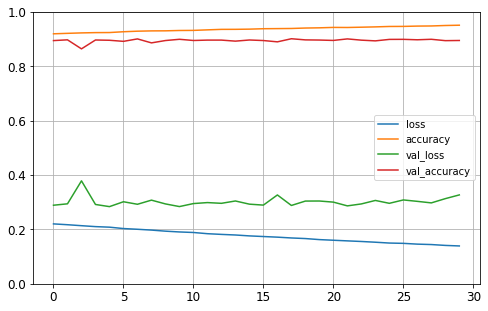

In [47]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

The validation curves are close to the training curves, which means that there is not too much overfitting.

If the validation loss is still going down, you can call the `fit()` method again, Keras just continues training where it left off. 

Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production.

In [48]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 883us/step - loss: 0.3611 - accuracy: 0.8862


[0.3610770106315613, 0.8862000107765198]

## Using the model to make predictions

In [49]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.96, 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [50]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [51]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

The actual values: 

In [52]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

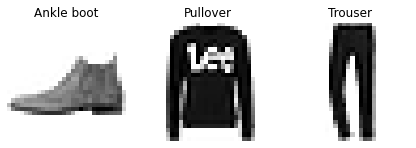

In [53]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2). It contains only numerical features (there is no ocean_proximity feature), and there is no missing value.

In [55]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [62]:
y_test

array([0.477  , 0.458  , 5.00001, ..., 1.177  , 2.631  , 4.815  ])

The main differences between regression and classification MLP are:
- the output layer has a single neuron (since we only want to predict a single value) 
- no output activation function
- the loss function is the mean squared error
- since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting:

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
print(mse_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 647us/step - loss: 1.8376 - val_loss: 1.0720
Epoch 2/20
363/363 [==============================] - 0s 512us/step - loss: 0.6953 - val_loss: 0.6397
Epoch 3/20
363/363 [==============================] - 0s 528us/step - loss: 0.6373 - val_loss: 0.5960
Epoch 4/20
363/363 [==============================] - 0s 539us/step - loss: 0.6050 - val_loss: 0.5744
Epoch 5/20
363/363 [==============================] - 0s 502us/step - loss: 0.5785 - val_loss: 0.5613
Epoch 6/20
363/363 [==============================] - 0s 553us/step - loss: 0.5558 - val_loss: 0.5296
Epoch 7/20
363/363 [==============================] - 0s 528us/step - loss: 0.5369 - val_loss: 0.5063
Epoch 8/20
363/363 [==============================] - 0s 534us/step - loss: 0.5214 - val_loss: 0.5133
Epoch 9/20
363/363 [==============================] - 0s 478us/step - loss: 0.5074 - val_loss: 0.4940
Epoch 10/20
363/363 [==============================] - 0s 486us/step - loss: 0.495

## Saving and Restoring a model

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [64]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 740us/step - loss: 1.9365 - val_loss: 0.9031
Epoch 2/10
363/363 [==============================] - 0s 601us/step - loss: 0.8190 - val_loss: 1.0513
Epoch 3/10
363/363 [==============================] - 0s 565us/step - loss: 0.7130 - val_loss: 0.8212
Epoch 4/10
363/363 [==============================] - 0s 558us/step - loss: 0.6523 - val_loss: 0.6161
Epoch 5/10
363/363 [==============================] - 0s 573us/step - loss: 0.6068 - val_loss: 0.5660
Epoch 6/10
363/363 [==============================] - 0s 570us/step - loss: 0.5677 - val_loss: 0.5504
Epoch 7/10
363/363 [==============================] - 0s 565us/step - loss: 0.5361 - val_loss: 0.5486
Epoch 8/10
363/363 [==============================] - 0s 587us/step - loss: 0.5093 - val_loss: 0.4784
Epoch 9/10
363/363 [==============================] - 0s 554us/step - loss: 0.4855 - val_loss: 0.4774
Epoch 10/10
162/162 [==============================] - 0s 378us/step - loss: 0.452

In [66]:
model.save("my_keras_model.h5")

In [67]:
model = keras.models.load_model("my_keras_model.h5")

In [68]:
model.predict(X_new)

array([[0.6716645],
       [1.4356503],
       [3.3700979]], dtype=float32)

## Using Callbacks during Training

In [69]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [70]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

The `fit()` method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch.

- You can implement early stopping by using the `EarlyStopping` callback. 
- It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the `patience` argument), and it will optionally roll back to the best model.


In [71]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 0s 749us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/100
363/363 [==============================] - 0s 558us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/100
363/363 [==============================] - 0s 527us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/100
363/363 [==============================] - 0s 614us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/100
363/363 [==============================] - 0s 557us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/100
363/363 [==============================] - 0s 608us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/100
363/363 [==============================] - 0s 581us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/100
363/363 [==============================] - 0s 526us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/100
363/363 [==============================] - 0s 571us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/100
363/363 [==============================] - 0s 563us/step - l

The number of epochs can be set to a large value since training will stop automatically when there is no more progress.

# Hyperparameter Tuning

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. 
- network architecture
- number of layers
- number of neurons per layer
- type of activation function to use in each layer
- the weight initialization logic
- ...

How do you know what combination of hyperparameters is the best for your task?

## Number of Hidden Layers
- For many problems, you can begin with a single hidden layer and get reasonable results.
- For complex problems, deep networks have a much higher parameter efficiency than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing them to reach much better performance with the same amount of training data.
- Real-world data is often structured in  a hierarchical way, and deep neural networks automatically take advantage of this fact: 
  - lower hidden layers model lowlevel structures (e.g., line segments of various shapes and orientations)
  - intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g., squares, circles)
  - the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g., faces)
- Not only does this hierarchical architecture help DNNs converge faster to a good solution, but it also improves their ability to generalize to new datasets.
  - For example, if you have already trained a model to recognize faces in pictures and you now want to train a new neural network to recognize hairstyles, you can kickstart the training by **reusing the lower layers of the first network**.
  - Instead of randomly initializing the weights and biases of the first few layers of the new neural network, you can initialize them to the values of the weights and biases of the lower layers of the first network.
  - This way the network will not have to learn from scratch all the low-level structures that occur in most pictures; it will only have to learn the higher-level structures (e.g., hairstyles). - This is called _transfer learning_.


## Number of Neurons per Hidden Layer
- The number of neurons in the input and output layers is determined by the type of input and output your task requires.
- In general it's fine to use the same number of neurons in each hidden layer. 
- Depending on the dataset, it can sometimes help to make the first hidden layer bigger than the others.
- Just like the number of layers, you can try increasing the number of neurons gradually until the network starts overfitting. 
- But in practice, it’s often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting.

## Learning Rate, Batch Size, and Other Hyperparameters
### Learning Rate
- most important hyperparameter
- train the model for a few hundred iterations, starting with a very low learning rate (e.g., $10^{-5}$) and gradually increase it up to a very large value (e.g., $10$).
- this is done by multiplying the learning rate by a constant factor at each iteration. 
### Optimizer
- Choosing a better optimizer than plain old Mini-batch Gradient Descent (and tuning its hyperparameters) is also quite important. 
- We will see several advanced optimizers in Chapter 11.
### Batch size
- can have a significant impact on your model’s performance and training time
- the main benefit of using large batch sizes is that hardware accelerators like GPUs can process them efficiently, so the training algorithm will see more
instances per second.
- there’s a catch, though: in practice, large batch sizes often lead to training instabilities, especially at the beginning of training, and the resulting model may not generalize as well as a model trained with a small batch size.